# CA684 Machine Learning Assignment Spring 2022

Dublin City University has teamed up with leading online fashion retailer Zalando to create the 2022 CA684 Machine Learning assignment.

## Introduction

As a customer proposition, Zalando strives for “trustworthy” prices. That is, the company wants to offer competitive prices in each of its dynamic market environments, to alleviate its customers from having to compare prices, and to drive revenue growth. In order to do that for its hundreds of thousands of individual products, Zalando needs to Identify exact product matches across the relevant European competitors. 

A very similar use case exists at stores like Amazon or Walmart, which allow multiple sellers to offer the same product on their platform: identical products need to be grouped together, even when the names, descriptions, images, etc. are not exactly the same.

## Challenge

Barcode systems like EAN allow for unique identification of every product. Unfortunately, reliable EAN information is not always available. Zalando uses multi-modal data to solve the problem, relying on images and text. For this challenge, we are asking to make intelligent use of text data (such as product titles, colors and descriptions). As these are not standardized, and often manually written / changed for marketing purposes, matching products is a non-trivial task.

This challenge has a direct business impact for a retailer like Zalando. It is also closely related to many other problems, like record deduplication in heterogeneous catalogues, document retrieval, and many more.

## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib
from random import choices
from itertools import chain
# Levenshtein Distance in Python
# https://github.com/seatgeek/thefuzz
from thefuzz import fuzz, process

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# set random seed
np.random.seed(seed=42)

## Dataset

The dataset will contain files as follows. 

* Two files containing **offers of products**, for training and testing respectively. An offer is a particular description of a product by an online shop, either Zalando or one of its competitors. They contains the following fields:

| Label | Description |
|:-----:|:------------|
| offer_id | unique identifier for an offer of a product (i.e. a product x shop combination, where we don’t know the product component) |
| shop | "zalando", "aboutyou" |
| lang | "de" (German) |
| brand | e.g. "Nike" - note that different `shop`s might have different `brand` nomenclature |
| color | e.g. "blue" - note that there could be more than one and different `shop`s might have different `brand` nomenclature ("ocean", "light blue", "...") and may have more than one color (ordering matters) |
| title | e.g. "White Nike tennis top" |
| description | a long product description that can may contain material composition, cleaning instructions, etc |
| price | price in euro without any discount |
| url | url of the product description page |
| image_urls | list of product images such as stock photo, with model, lifestyle photo, or close up |

* A separate file containing the **matches** in between those offers that describe the same products using the offer id. Note this is only provided for the training offers.

| Label | Description |
|:-----:|:------------|
| zalando | offer_id from “zalando” shop |
| aboutyou | offer_id from “aboutyou” shop |
| brand | unique identifier for the brand representing the match |


In [3]:
!ls {offers,matches}_{training,test}.parquet

ls: matches_test.parquet: No such file or directory
matches_training.parquet offers_test.parquet      offers_training.parquet


## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the matching task!

### Offers of Products

In [4]:
offers_training_df = pd.read_parquet('offers_training.parquet')

In [5]:
f'Number of products in training: {len(offers_training_df):,}'

'Number of products in training: 102,884'

In [6]:
list(offers_training_df.columns)

['offer_id',
 'shop',
 'lang',
 'brand',
 'color',
 'title',
 'description',
 'price',
 'url',
 'image_urls']

In [7]:
offers_training_df.head(4)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige | Beige,Chino-Hose,"{""Marke"": [""MAMALICIOUS""], ""Gr\u00f6\u00dfenla...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...
3,556e8f61-b1d7-4d72-8bae-d74f9357270b,aboutyou,de,rosemunde,rosa | Pink,Top / Seidentop,"{""Marke"": [""rosemunde""], ""Zielgruppe"": [""Femal...",49.99,https://www.aboutyou.de/p/rosemunde/top-seiden...,[https://cdn.aboutstatic.com/file/images/3cf28...


In [8]:
offers_training_df['lang'].unique()

array(['de'], dtype=object)

In [9]:
pd.value_counts(offers_training_df['shop'], sort=True, ascending=False)

aboutyou    61980
zalando     40904
Name: shop, dtype: int64

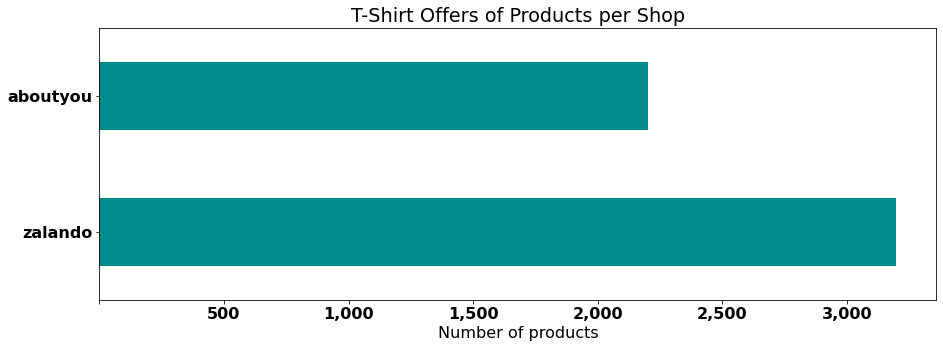

In [10]:
figure, ax = plt.subplots(figsize=(15, 5))
pd.value_counts(
    offers_training_df[
        offers_training_df['title'].str.lower().str.contains("t-shirt", na=False)
    ]['shop'], 
    sort=True, ascending=False).plot.barh(color='darkcyan')
plt.title('T-Shirt Offers of Products per Shop')
xlabels = [f'{x:,}' for x in range(0, 3500, 500)]
plt.xticks(range(0, 3500, 500), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

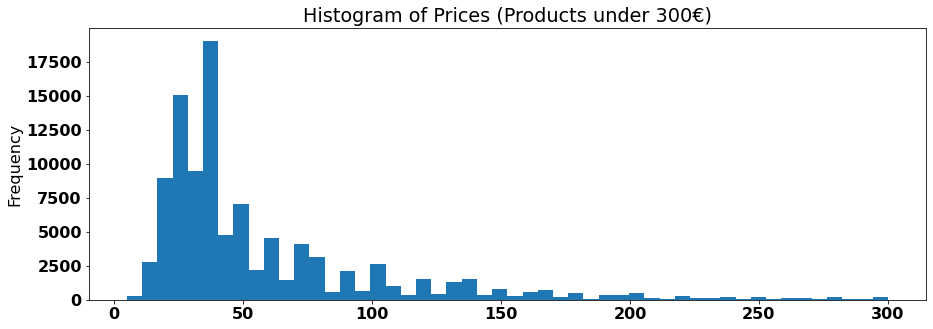

In [11]:
figure, ax = plt.subplots(figsize=(15, 5))
plt.title('Histogram of Prices (Products under 300€)')
offers_training_df[
    offers_training_df['price'] < 300
]['price'].plot.hist(bins=50)
plt.show()

In [12]:
brands_training = offers_training_df['brand'].unique()

In [13]:
brands_training[:5]

array(['PIECES', 'LASCANA', 'MAMALICIOUS', 'rosemunde', 'Guess'],
      dtype=object)

In [14]:
f'Number of unique brands in training: {len(brands_training):,}'

'Number of unique brands in training: 145'

In [15]:
offers_test_df = pd.read_parquet('offers_test.parquet')

In [16]:
f'Number of products in test: {len(offers_test_df):,}'

'Number of products in test: 106,741'

In [17]:
brands_test = offers_test_df['brand'].unique()

In [18]:
f'Number of unique brands in test: {len(brands_test):,}'

'Number of unique brands in test: 164'

**Note** that Brands in training and test are different!

In [19]:
# Intersection between brands in training and test
f'Number of brands in train and test: {sum(np.in1d(brands_training, brands_test, assume_unique=True)):,}'

'Number of brands in train and test: 0'

### Matches

**Note** that matches for the offers in testing are hidden!

In [20]:
matches_training_df = pd.read_parquet('matches_training.parquet')

In [21]:
f'Number of groundtruth matches: {len(matches_training_df):,}'

'Number of groundtruth matches: 15,170'

In [22]:
matches_training_df.head()

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10


In [23]:
matches_training_df.iloc[0]

zalando     b33f55d6-0149-4063-8b63-3eeae63562a2
aboutyou    ad5ceb87-0254-4171-b650-1d4d09f48efc
brand                                         10
Name: 0, dtype: object

In [24]:
def get_offer(products, match, shop):
    return products[
        products['offer_id'] == match[shop]
    ].iloc[0]

In [25]:
f"Number of unique brands in training matches: {len(offers_training_df['brand'].unique()):,}"

'Number of unique brands in training matches: 145'

In [26]:
def plot_images(product):
    
    # Data
    images = product['image_urls']
    
    # Plot it!
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 4), dpi=100)
    
    if len(images) > 1:     
        axes = axes.flatten()
        for i, axis in enumerate(axes):
            url = images[i]
            image = np.array(Image.open(urllib.request.urlopen(url)))
            axis.imshow(image)
            axis.axis('off')
    else:
        url = images[0]
        image = np.array(Image.open(urllib.request.urlopen(url)))
        axes.imshow(image)
        axes.axis('off')

    fig.tight_layout()
    plt.show()

In [27]:
index = 9209 # particular index
product = get_offer(offers_training_df, matches_training_df.iloc[index], 'zalando')
product

offer_id                    dbf70606-78ba-4f93-93af-4b6ecdf15006
shop                                                     zalando
lang                                                          de
brand                                                 Quiksilver
color                                                 dunkelblau
title                                        WBLCKVLY Badeshorts
description    main_supplier_code K71108 $ skirt_details elas...
price                                                  45.990909
url            https://www.zalando.de/lookup/article/QU182H06...
image_urls     [https://img01.ztat.net/article/92e131720efc31...
Name: 21753, dtype: object

Zalando


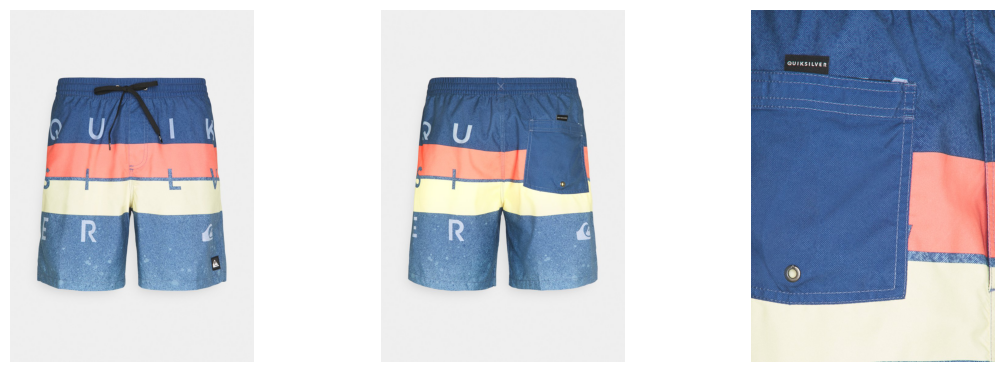

In [28]:
print('Zalando')
plot_images(product)

In [29]:
product = get_offer(offers_training_df, matches_training_df.iloc[index], 'aboutyou')
product

offer_id                    d2accc74-68bd-4b06-88ff-8b9a42e20058
shop                                                    aboutyou
lang                                                          de
brand                                                 QUIKSILVER
color                                                blau | Blau
title                                                 Badeshorts
description    {"Zielgruppe": ["Male"], "Marke": ["QUIKSILVER...
price                                                       49.9
url            https://www.aboutyou.de/p/quiksilver/badeshort...
image_urls     [https://cdn.aboutstatic.com/file/images/c95f4...
Name: 425, dtype: object

AboutYou


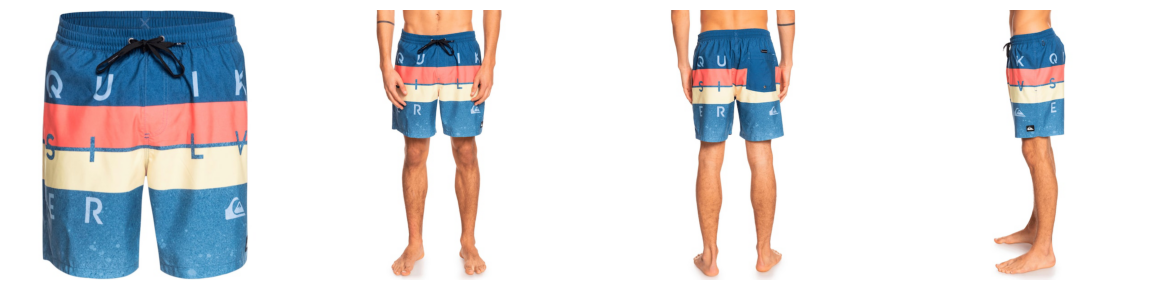

In [30]:
print('AboutYou')
plot_images(product)

## Matching

The task is to predict the matches for the offers in testing making use of the offers in training and the corresponding groundtruth matches. Feel free to use any Machine Learning library you like such as Pytorch, TensorFlow or scikit-learn. An idea is to split the training data into train and validation to measure the generalizability of your approach. The following is just a slow and dummy algorithm to get you started just looking at a few brands.

**Note** that it might help map brands first between Zalando and AboutYou.

Get creative!

In [31]:
def get_shops_for_brand(offers, brands):
    """ Get mapping for brands in between the two shops """
    
    mapping = {}
    for brand in brands:
        shops = offers[offers["brand"] == brand]["shop"].unique()
        for shop in shops:
            mapping.setdefault(shop, [])
            mapping[shop].append(brand)
        print(f'Brand: "{brand}" is in {", ".join(shops)}')
    return mapping

In [32]:
def get_offers_by_shop(offers, mapping):
    """ Get offers per shop """
    
    offers_zal = offers[
        (offers['shop'] == 'zalando') & 
        (offers['brand'].isin(mapping['zalando']))
    ]
    offers_comp = offers[
        (offers['shop'] == 'aboutyou') &
        (offers['brand'].isin(mapping['aboutyou']))
    ]
    return offers_zal, offers_comp

In [33]:
def get_features(offers):
    """ Extract some text features using title and color """
    
    offers['text'] = offers[
        ['title','color']
    ].apply(lambda x : f"{x[0]} {x[1].split('|')[0]}", axis=1)
    
    return offers[['offer_id', 'text']].values

In [34]:
def dummy_matcher(zal_offers, comp_offers, brand_block_index):
    """
    Slow and dummy matcher that matches each Zalando offer to an AboutYou offer 
    Note: there is no need to match all offers as not all of them can be matched
    """
    
    # Get text from offers
    comp_text = comp_offers[:, 1]
    choices_dict = {idx: el for idx, el in enumerate(comp_text)}
    
    predicted_matches = []

    # For each zalando offer
    for zal_offer_id, zal_text in zal_offers:
        
        # Extract the best match using TheFuzz's package
        title, score, index = process.extractOne(zal_text, choices_dict) 
        comp_offer_id = comp_offers[index][0]

        # Add predicted match
        predicted_matches.append(
            {
                'zalando': zal_offer_id,
                'aboutyou': comp_offer_id,
                'brand': brand_block_index
            }
        )

    return pd.DataFrame(predicted_matches)

In [35]:
def get_brand_predictions(brand_pattern, brand_unique_index):
    """ 
    Custom pipeline to get the brand mapping, offers per shop, extract the features and generate predictions
    """

    list_brands = [
        brand
        for brand in brands_training
        if brand_pattern in brand.lower()
    ]

    # Get brand mapping
    brand_mapping = get_shops_for_brand(offers_training_df, list_brands)
    print(f'Mapping: {brand_mapping}')

    # Get offers
    brand_offers_zal, brand_offers_comp = get_offers_by_shop(offers_training_df, brand_mapping)
    
    print(f'Number of "{brand_pattern}" products: {len(brand_offers_zal) + len(brand_offers_comp):,} (' + \
          f'Zalando: {len(brand_offers_zal):,} ' + \
          f'and AboutYou: {len(brand_offers_comp):,})')

    # Get features
    brand_offers_zal_features = get_features(brand_offers_zal)
    brand_offers_comp_features = get_features(brand_offers_comp)

    # Match!
    predictions = dummy_matcher(
        brand_offers_zal_features, 
        brand_offers_comp_features, 
        brand_unique_index
    )
    
    print(f'Number of predicted matches for "{brand_pattern}": {len(predictions):,}')
    
    return brand_offers_zal, brand_offers_comp, predictions

In [36]:
quiksilver_offers_zal, quiksilver_offers_comp, quiksilver_predicted_matches = get_brand_predictions('quiksilver', 0)

Brand: "QUIKSILVER" is in aboutyou
Brand: "Quiksilver" is in zalando
Mapping: {'aboutyou': ['QUIKSILVER'], 'zalando': ['Quiksilver']}
Number of "quiksilver" products: 847 (Zalando: 506 and AboutYou: 341)
Number of predicted matches for "quiksilver": 506


In [37]:
burberry_offers_zal, burberry_offers_comp, burberry_predicted_matches = get_brand_predictions('burberry', 1)

Brand: "BURBERRY" is in aboutyou
Brand: "Burberry" is in zalando
Mapping: {'aboutyou': ['BURBERRY'], 'zalando': ['Burberry']}
Number of "burberry" products: 724 (Zalando: 110 and AboutYou: 614)
Number of predicted matches for "burberry": 110


In [38]:
veja_offers_zal, veja_offers_comp, veja_predicted_matches = get_brand_predictions('veja', 2)

Brand: "Veja" is in zalando, aboutyou
Mapping: {'zalando': ['Veja'], 'aboutyou': ['Veja']}
Number of "veja" products: 260 (Zalando: 243 and AboutYou: 17)
Number of predicted matches for "veja": 243


## Evaluation

Now that we just learned some mapping between the offers and the matches, we can evaluate the performance of our matching algorithm. In a qualitative way, we can explore the matches using the actual images as we can quickly figure out whether that is actually a match or not. In a quantitative manner, we can measure its performance leveraging F1, precision and recall metrics after calculating the confusion matrix between actual matches and the predicted ones. 

The goal of the assignment is to maximize F1 overall!

In [39]:
def explore_match(match):
    """ Explore a match with the offers' images """
    
    # get offer ids
    zal_offer_id = match['zalando']
    comp_offer_id = match['aboutyou']
    
    # get offers
    zalando_offer = offers_training_df[offers_training_df['offer_id'] == zal_offer_id].iloc[0]
    comp_offer = offers_training_df[offers_training_df['offer_id'] == comp_offer_id].iloc[0]
    
    # show images and text
    print(f"Zalando: {zalando_offer['title']} {zalando_offer['color']}")
    plot_images(zalando_offer)
    print(f"AboutYou: {comp_offer['title']} {zalando_offer['color']}")
    plot_images(comp_offer)

In [40]:
def get_true_matches_brand(zal_offers):
    """ Get true matches based on their brand block """
    
    # get brand block / mapping index from the training matches
    indexes = zal_offers.merge(
        matches_training_df,
        left_on='offer_id',
        right_on='zalando',
        suffixes=['offer', 'match']
    )['brandmatch'].unique()
    
    return matches_training_df[matches_training_df['brand'].isin(indexes)]

In [41]:
def get_metrics(true_matches, predicted_matches, offers_comp):
    """ Calculate performance metrics """
    
    # True Positives
    TP = len(
        true_matches.merge(
            predicted_matches, 
            on=['zalando', 'aboutyou'], 
            how='inner', 
        )
    )
    
    # False Negatives
    FN = len(true_matches) - TP
    
    # Actual Positives
    positives = len(true_matches)
    assert positives == TP + FN
    
    # Actual Negatives (with respect to the competitor)
    negatives = len(offers_comp) - positives
    
    # Actual negative values (with respect to the competitor)
    offers_comp_with_matches = offers_comp.merge(
        true_matches, 
        left_on='offer_id',
        right_on='aboutyou',
        how='outer',
        indicator=True
    )
    negative_values = offers_comp_with_matches[
        offers_comp_with_matches['_merge'] == 'left_only'
    ]['offer_id'].unique()
    
    assert negatives == len(negative_values)
    
    # Competitor predictions
    comp_preds = predicted_matches['aboutyou'].unique()
    
    # False Negatives (with respect to the competitor)
    FP = len(np.intersect1d(negative_values, comp_preds))
    
    # True Negatives
    TN = negatives - FP
    
    # Precision, Recall and F1 metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 0
    if precision + recall > 0:
        F1 = 2 * precision * recall / (precision + recall)
    
    metrics = dict(
        TP=TP,
        FN=FN,
        FP=FP,
        TN=TN,
        positives=positives,
        negatives=negatives,
        precision=precision,
        recall=recall,
        F1=F1,
    )
        
    return metrics

In [42]:
def get_brand_metrics(brand_offers_zal, brand_offers_comp, brand_predicted_matches):

    # Get groundtruth
    brand_true_matches = get_true_matches_brand(brand_offers_zal)
    
    print(f'Number of true matches: {len(brand_true_matches):,}')

    # Get metrics
    brand_metrics = get_metrics(brand_true_matches, brand_predicted_matches, brand_offers_comp)
    
    return brand_true_matches, brand_metrics

Zalando: SYCAMORE Skijacke Snowboardjacke oliv


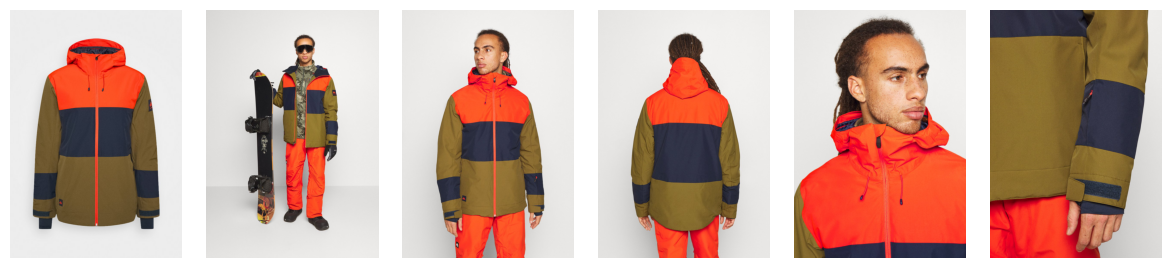

AboutYou: Jacke oliv


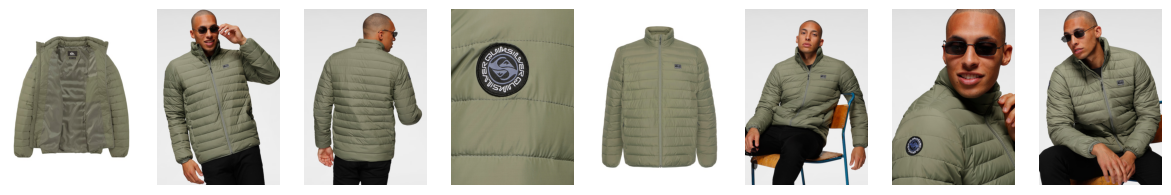

In [43]:
# Explore a particular predicted match
predicted_match = quiksilver_predicted_matches.iloc[27]
explore_match(predicted_match)

Not a correct match!

Let's see some details:

In [44]:
get_offer(offers_training_df, predicted_match, 'zalando')

offer_id                    7d779be3-68b5-4a3f-b7cf-b19d31c48f7d
shop                                                     zalando
lang                                                          de
brand                                                 Quiksilver
color                                                       oliv
title                           SYCAMORE Skijacke Snowboardjacke
description    main_supplier_code K71108 $ sport_jacket_detai...
price                                                 229.990909
url            https://www.zalando.de/lookup/article/QU142F03...
image_urls     [https://img01.ztat.net/article/786fafbb64b639...
Name: 4388, dtype: object

In [45]:
get_offer(offers_training_df, predicted_match, 'aboutyou')

offer_id                    dde31094-36ef-4d98-abfc-12f46652f24e
shop                                                    aboutyou
lang                                                          de
brand                                                 QUIKSILVER
color                                                oliv | Grün
title                                                      Jacke
description    {"Jackenart": ["Steppjacke"], "Marke": ["QUIKS...
price                                                      89.99
url            https://www.aboutyou.de/p/quiksilver/jacke-710...
image_urls     [https://cdn.aboutstatic.com/file/images/6d608...
Name: 97296, dtype: object

Zalando: SYCAMORE Skijacke Snowboardjacke oliv


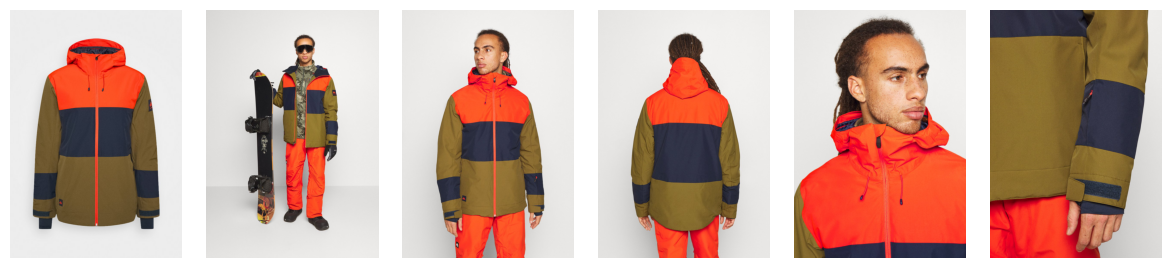

AboutYou: Skijacke oliv


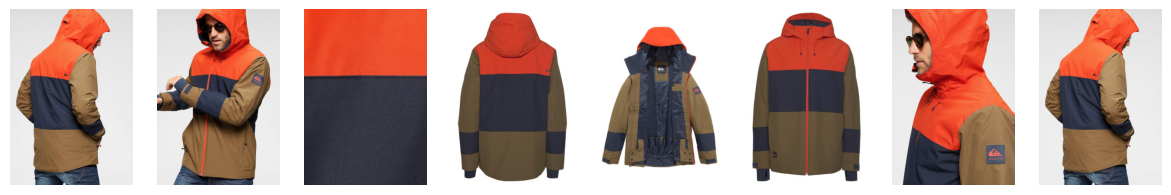

In [46]:
# Groundtruth match (note: there is a true match for this particular offer)
true_match = matches_training_df[
    matches_training_df['zalando'] == quiksilver_predicted_matches.iloc[27]['zalando']
].iloc[0]
explore_match(true_match)

In [47]:
quiksilver_true_matches, quiksilver_metrics = get_brand_metrics(
    quiksilver_offers_zal, quiksilver_offers_comp, quiksilver_predicted_matches)
quiksilver_metrics

Number of true matches: 98


{'TP': 10,
 'FN': 88,
 'FP': 54,
 'TN': 189,
 'positives': 98,
 'negatives': 243,
 'precision': 0.15625,
 'recall': 0.10204081632653061,
 'F1': 0.1234567901234568}

Let's look at some of these results!

For Quiksilver, we figured out 10 matches, true positives, out of the 98 actual matches (positives) by just using the title and color of the offers. Hence, 88 were false negatives, we failed to predict them as matches. In terms of the actual negatives, there were 243 offers in AboutYou that did not have a corresponding match. We predicted 54 of those to have a match but in reality they did not any, those are our false positives. The rest are correct true negatives.

In [48]:
burberry_true_matches, burberry_metrics = get_brand_metrics(
    burberry_offers_zal, burberry_offers_comp, burberry_predicted_matches)
burberry_metrics

Number of true matches: 45


{'TP': 3,
 'FN': 42,
 'FP': 11,
 'TN': 558,
 'positives': 45,
 'negatives': 569,
 'precision': 0.21428571428571427,
 'recall': 0.06666666666666667,
 'F1': 0.10169491525423728}

In [49]:
veja_true_matches, veja_metrics = get_brand_metrics(veja_offers_zal, veja_offers_comp, veja_predicted_matches)
veja_metrics

Number of true matches: 14


{'TP': 4,
 'FN': 10,
 'FP': 3,
 'TN': 0,
 'positives': 14,
 'negatives': 3,
 'precision': 0.5714285714285714,
 'recall': 0.2857142857142857,
 'F1': 0.38095238095238093}

Let's measure our metrics over all the offers in the groundtruth. **Note** that there is no need to perform predictions per brand block, it is just an approach used in this notebook to showcase matches and not matches.

In [50]:
offers_zal = offers_training_df[offers_training_df['shop'] == 'zalando']
offers_comp = offers_training_df[offers_training_df['shop'] == 'aboutyou']

In [51]:
predicted_matches = pd.concat([
    quiksilver_predicted_matches,
    burberry_predicted_matches,
    veja_predicted_matches
])

In [52]:
get_metrics(matches_training_df, predicted_matches, offers_comp)

{'TP': 17,
 'FN': 15153,
 'FP': 68,
 'TN': 46742,
 'positives': 15170,
 'negatives': 46810,
 'precision': 0.2,
 'recall': 0.0011206328279499012,
 'F1': 0.0022287774500163882}

The goal of the assignment is to maximize that F1 over all the test offers!

## Submission

Prepare a submission for matching the test offers between Zalando and AboutYou. The following example makes predictions for just a few brand blocks that are identified from the test offers. The objective is to make predictions for all test offers. Remember not all of them will have matches!

Happy Hacking!

In [53]:
dkny_brands = [
    brand
    for brand in brands_test
    if 'dkny' in brand.lower()
]

dkny_brand_mapping = get_shops_for_brand(offers_test_df, dkny_brands)
dkny_brand_mapping

Brand: "DKNY" is in aboutyou, zalando
Brand: "DKNY Performance" is in aboutyou
Brand: "DKNY Intimates" is in aboutyou
Brand: "DKNY Sport" is in aboutyou


{'aboutyou': ['DKNY', 'DKNY Performance', 'DKNY Intimates', 'DKNY Sport'],
 'zalando': ['DKNY']}

In [54]:
gant_brands = [
    brand
    for brand in brands_test
    if 'gant' in brand.lower()
]

gant_brand_mapping = get_shops_for_brand(offers_test_df, gant_brands)
gant_brand_mapping

Brand: "GANT" is in aboutyou
Brand: "Gant" is in zalando


{'aboutyou': ['GANT'], 'zalando': ['Gant']}

In [55]:
# Brand mappings for brands in test offers
test_mapping = [
    dkny_brand_mapping,
    gant_brand_mapping
]

In [56]:
def get_test_predictions(mapping):
    """ Predicts brands per block for the test set """
    
    predictions = []

    for brand_index, brand_mapping in enumerate(mapping):

        print(f'Predicting for block {", ".join(list(chain.from_iterable(brand_mapping.values())))}...')

        # Get offers
        brand_offers_zal, brand_offers_comp = get_offers_by_shop(offers_test_df, brand_mapping)
        print(f'Number of offers: {len(brand_offers_zal) + len(brand_offers_comp):,}')

        # Get features
        brand_offers_zal_features = get_features(brand_offers_zal)
        brand_offers_comp_features = get_features(brand_offers_comp)

        # Match!
        brand_pred_matches = dummy_matcher(
            brand_offers_zal_features, 
            brand_offers_comp_features, 
            brand_index
        )
        print(f'Number of matches: {len(brand_pred_matches):,}')

        # Add the predictions
        predictions.append(brand_pred_matches)

    return pd.concat(predictions)

In [57]:
predictions_df = get_test_predictions(test_mapping)

Predicting for block DKNY, DKNY Performance, DKNY Intimates, DKNY Sport, DKNY...
Number of offers: 2,079
Number of matches: 932
Predicting for block GANT, Gant...
Number of offers: 3,608
Number of matches: 1,344


In [58]:
predictions_df.to_parquet('matches_test_predicted.parquet')